Corpus statistics
- Number of sentences.
- Number of word forms (tokens).
- Number of distinct word forms (types).
- Sentence length in characters and words.
- Word form length.
- Word forms with frequency=1
- Most frequent words.
- Zipf’s law
- Most frequent bigrams, trigrams, etc

In [9]:
import numpy as np
import pandas as pd
from collections import Counter

In [4]:
with open("data/slk_newscrawl_2016_1M/slk_newscrawl_2016_1M-sentences.txt", "r", encoding="utf-8") as f:
    # read lines and split at tab, keep only second column
    df = pd.DataFrame(
        [line.strip().split("\t")[1] for line in f.readlines()], columns=["sentence"]
    )
    display(df.head())

,sentence
0,! 00:01 Nestrapnuj sa krcmovymi frajerinami a ...
1,"007iwb, platený diskuter, ktorý v každej debat..."
2,01:15 - tvoj mozog plný fekálií je schopný iba...
3,"01. apríl 2014, 07:18 Počet obetí zosuvu pôdy ..."
4,"01. apríl 2014, 14:33 Nora Mojsejová na slobode?"


In [10]:
# number of sentences
num_sentences = len(df)
print(f"Number of sentences: {num_sentences}")

# number of tokens
df["num_tokens"] = df["sentence"].apply(lambda x: len(x.split()))
total_tokens = df["num_tokens"].sum()
print(f"Total number of tokens: {total_tokens}")

# number of types
all_tokens = " ".join(df["sentence"]).split()
unique_tokens = set(all_tokens)
num_types = len(unique_tokens)
print(f"Number of unique tokens (types): {num_types}")

# sentence length in characters
df["num_characters"] = df["sentence"].apply(len)
avg_sentence_length_chars = df["num_characters"].mean()
print(f"Average sentence length (characters): {avg_sentence_length_chars:.2f}")

# sentence length in tokens
avg_sentence_length_tokens = df["num_tokens"].mean()
print(f"Average sentence length (tokens): {avg_sentence_length_tokens:.2f}")

# word form length
df["word_lengths"] = df["sentence"].apply(lambda x: [len(word) for word in x.split()])
all_word_lengths = [length for sublist in df["word_lengths"] for length in sublist]
avg_word_length = np.mean(all_word_lengths)
print(f"Average word form length (characters): {avg_word_length:.2f}")

# word forms with frequency 1
word_counts = Counter(all_tokens)
hapax_legomena = [word for word, count in word_counts.items() if count == 1]
num_hapax_legomena = len(hapax_legomena)
print(f"Number of word forms with frequency 1 (hapax legomena): {num_hapax_legomena}")

Number of sentences: 1000000
Total number of tokens: 16210740
Number of unique tokens (types): 1092409
Average sentence length (characters): 107.19
Average sentence length (tokens): 16.21
Average word form length (characters): 5.67
Number of word forms with frequency 1 (hapax legomena): 649061


In [11]:
# most frequent words
most_common_words = word_counts.most_common(10)
print("Most frequent words:")
for word, count in most_common_words:
    print(f"  {word}: {count}")

Most frequent words:
  v: 343121
  a: 330315
  na: 325468
  sa: 310920
  je: 161956
  aj: 119517
  že: 117498
  o: 107967
  to: 105263
  s: 105125


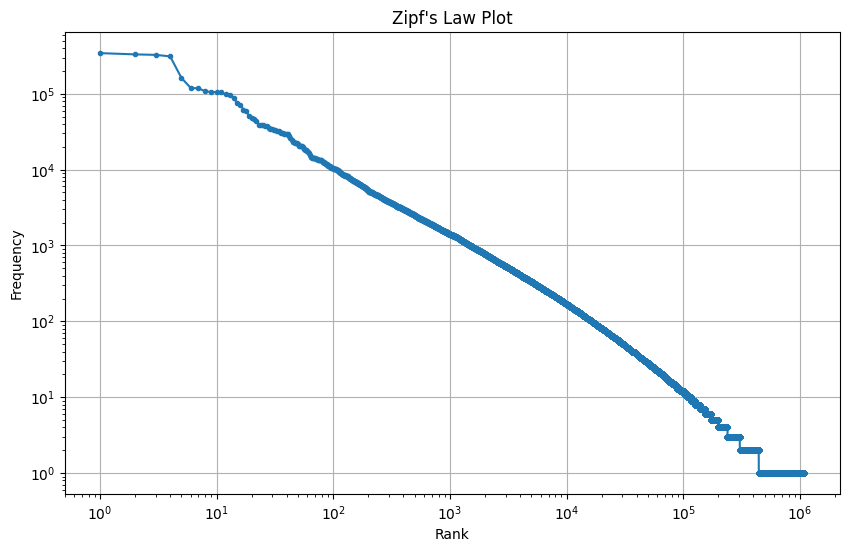

In [13]:
# zipf's law plot
import matplotlib.pyplot as plt
sorted_word_counts = sorted(word_counts.values(), reverse=True)
ranks = np.arange(1, len(sorted_word_counts) + 1)
plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_word_counts, marker=".")
plt.title("Zipf's Law Plot")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# most frequent bigrams and trigrams
from nltk import ngrams
all_bigrams = ngrams(all_tokens, 2)
all_trigrams = ngrams(all_tokens, 3)
bigram_counts = Counter(all_bigrams)
trigram_counts = Counter(all_trigrams)
most_common_bigrams = bigram_counts.most_common(10)
most_common_trigrams = trigram_counts.most_common(10)
print("Most frequent bigrams:")
for bigram, count in most_common_bigrams:
    print(f"  {' '.join(bigram)}: {count}")
print("\nMost frequent trigrams:")
for trigram, count in most_common_trigrams:
    print(f"  {' '.join(trigram)}: {count}")

Most frequent bigrams:
  nie je: 15945
  Prečítajte si: 14243
  si exkluzívne: 14140
  exkluzívne prognózy: 14140
  prognózy TRENDU: 14140
  je to: 11603
  by sa: 11487
  v roku: 11347
  sa v: 10721
  do diskusie: 10290
Most frequent trigrams:
  Prečítajte si exkluzívne: 14140
  si exkluzívne prognózy: 14140
  exkluzívne prognózy TRENDU: 14140
  príspevku do diskusie: 10046
  pridanie príspevku do: 10045
  do diskusie sa: 10045
  diskusie sa musíte: 10045
  sa musíte prihlásiť.: 10045
  musíte prihlásiť. Prečítajte: 8535
  prihlásiť. Prečítajte si: 8535
